## **Step 1: Import packages**

In [79]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import ssl
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torchvision import transforms
from torchvision import datasets

from torch.optim.lr_scheduler import StepLR

ssl._create_default_https_context = ssl._create_unverified_context

## **Step 2: Set Up Hyper-Parameters for Fine Tuning:**


1.   Training process for Train/Validation data
2.   Train model and generate test data accuracy after fine tuning

In [80]:
# Batch size for each data iteration
# Make a change from 128 to 32
BATCH_SIZE = 128

# The ratio of split the validation set out of the original training set
VALID_RATIO = 0.1

# Learning Rate
LR = 0.01

# Kernel Size for the basic block of resnet
KERNEL_SIZE = 3

# Padding for the basic block of resnet
PADDING = 1

# Learning Rate Decay
LR_DECAY = 0.001

# Learning Rate Decay Period. For example, apply decay to learning rate every X epochs
LR_DECAY_PERIOD = 2

# ResNet's number of input channel
CHANNEL = 42

# Number of epoch
EPOCH_NUM = 30

# The following WEIGHT_DECAY and MOMENTUM and DAMPENING is for SGD Optimizer   
# Weight Decay
WEIGHT_DECAY = 0.001

# Dampening
# DAMPENING = 0.05

# Momentum
MOMENTUM = 0.9

##  **Step 3: Extract and Optimize the RAW CIFAR-10 Data:**

1.   Create folders for Model and Log data
2.   Split 10% of the RAW train data as valid data
3.   Customize the Transform process for train and test data
4.   Generate the:
    *   Train and Valid Data Iteration: 50,000 rows of data
    *   Train Data Iteration:           45,000 rows of data
    *   Valid Data Iteration:            5,000 rows of data
    *   Test Data Iteration:            10,000 rows of data

In [81]:
# Create folders for Model and Log data
!mkdir -p ./Train_With_Test_Log ./Train_With_Test_Model ./Train_With_Valid_Log ./Train_With_Valid_Model

In [82]:
# Design the Transform process for train and test data
def train_transform(x):
    image_aug = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914,0.4822,0.4465), 
                                                         (0.2023,0.1994,0.2010))])
    x = image_aug(x)
    return x

# Customize the Transform process for train and test data
def test_transform(x):
    image_aug = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914,0.4822,0.4465), 
                                                                                (0.2023,0.1994,0.2010))])
    x = image_aug(x)
    return x


In [83]:
# Download the RAW data                                
train_valid_ds = datasets.CIFAR10('Data', 
                                  train=True, 
                                  download=True, 
                                  transform=train_transform)
test_ds = datasets.CIFAR10('Data', 
                           train=False, 
                           download=True, 
                           transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
# Split 10% of the RAW train data as valid data
valid_ds_size = int(len(train_valid_ds) * VALID_RATIO)
train_ds_size = len(train_valid_ds) - valid_ds_size

# Split Train and Valid data
train_ds, valid_ds = torch.utils.data.random_split(train_valid_ds, [train_ds_size, valid_ds_size]) 


## **Step 4: Check Runtime's GPU Availability**


In [85]:
train_on_gpu = torch.cuda.is_available()
# check whether CUDA is available
if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    

CUDA is available


## **Step 5: Generate Train/Validation/Test Data Loader**

In [86]:
# Generate the:
# 1) Train and Valid Data Loader: 50,000 rows of data
# 2) Train Data Loader: 45,000 rows of data
# 3) Valid Data Loader: 5,000 rows of data
# 4) Test Data Loader: 10,000 rows of data

# Train and Valid Data Loader: 50,000 rows of data
train_valid_loader = torch.utils.data.DataLoader(train_valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

# Train Valid Data Loader (Removed the 5,000 row for Validation): 50,000 rows of data
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

# Valid Data Loader: 5,000 rows of data
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

# Test Data Loader: 10,000 rows of data
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Step 6: Build the ResNet Model Architecture**

In [87]:
# Build the Basic Block for ResNet Model
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=KERNEL_SIZE, stride=stride, padding=PADDING, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=KERNEL_SIZE,
                               stride=1, padding=PADDING, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [88]:
# ResNet Module
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = CHANNEL

        self.conv1 = nn.Conv2d(3, CHANNEL, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(CHANNEL)
        self.layer1 = self._make_layer(block, CHANNEL, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, CHANNEL*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, CHANNEL*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, CHANNEL*8, num_blocks[3], stride=2)
        self.linear = nn.Linear(CHANNEL*8, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project_customized_model():
    block = [2,2,2,2] # This is ResNet 18
    return ResNet(BasicBlock, block)

# **Step 7: Train the ResNet model and Classifying the Test Data**


*   Train the Training and Valid dataset with the the Fine Tuning Hyper Parameters
*   Calculate and print the Test Accuracy


In [89]:
from numpy.ma.core import exp
def train_with_test(net,
                    train_valid_loader,
                    test_loader,
                    batch_size,
                    channel,
                    epoch_num,
                    lr,
                    lr_decay,
                    weight_decay,
                    lr_decay_period,
                    momentum):

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    start_time = datetime.datetime.now()
    model_path = 'Train_With_Test_Model/' + str(start_time) + '_model.pt'
    best_test_acc = 0
    print('Start trainning, time: ', start_time)
    f = open("Train_With_Test_Log/" + str(start_time) + ".txt", 'a')
    f.write('This is the method from paper, without grey random\n')
    f.write('hyperparamter:\n')
    f.write('lr_decay_period:' + str(lr_decay_period) + '\n')
    f.write('batch_size:' + str(batch_size) + '\n')
    f.write('lr:' + str(lr) + '\n')
    f.write('epoch_num:' + str(epoch_num) + '\n')
    f.write('momentum:' + str(momentum) + '\n')
    f.write('weight_decay:' + str(weight_decay) + '\n')
    f.write('channel:' + str(channel) + '\n')
    f.write('Begin training, time: ' + str(start_time) + '\n')
    print("Total #Params: ", sum(p.numel() for p in net.parameters() if p.requires_grad))
    print("-----------------------------------------------------------------------------------------------------")
    line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
        "Epoch", "Train loss", "Test loss", "Train accuracy", "Test accuracy", "lr", "Running time")
    print(line_new)
    print("#####################################################################################################")
    for epoch in range(epoch_num):
        # Common Learning Rate Decay Method
        # if epoch != 0 and epoch % lr_decay_period == 0:
        #   print('-->Learning Rate before decay: ', lr)
        #   lr_decay = LR_DECAY
        #   # This is the core algorithm
        #   lr *= 1/(1+lr_decay*epoch_num)
        #   optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        #   print('***lr_decay: ', LR_DECAY)
        #   print('***lr after decay: ', lr)
        #   f.write('lr decays \n')


        # Exponential Learning Rate Decay Method
        # if epoch != 0 and epoch % lr_decay_period == 0:
        #   print('-->Learning Rate before decay: ', lr)
        #   lr_decay = LR_DECAY
        #   # This is the core algorithm
        #   lr *= exp(-lr_decay * epoch_num)
        #   optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        #   print('***lr_decay: ', LR_DECAY)
        #   print('***lr after decay: ', lr)
        #   f.write('lr decays \n')

        # Constant Learning Rate Decay Method
        if epoch != 0 and epoch % lr_decay_period == 0:
          print('-->Learning Rate before decay: ', lr)
          lr_decay = LR_DECAY
          # The following two lines is the core algorithm
          if(lr>0.002):
            lr*=lr_decay
          optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
          print('***lr_decay: ', LR_DECAY)
          print('***lr after decay: ', lr)
          f.write('lr decays \n')


        train_loss = 0.0
        train_acc = 0.0
        net.train()
        epoch_start_time = datetime.datetime.now()
        for i, train_data in enumerate(train_valid_loader):
            inputs, labels = train_data
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            # forward + backward
            predicted_output = net(inputs)
            fit = loss(predicted_output, labels)
            fit.backward()
            # fit.sum().backward()
            optimizer.step()
            train_loss += fit.item()
            _, pred = predicted_output.max(1)
            num_correct = (pred == labels).sum().item()
            acc = num_correct / inputs.shape[0]
            train_acc += acc
        train_loss = train_loss / len(train_valid_loader)
        train_loss_history.append(train_loss)
        train_acc = train_acc / len(train_valid_loader)
        train_acc_history.append(train_acc)
        test_loss = 0.0
        test_acc = 0.0

        net.eval()
        for j, data in enumerate(test_loader):
            with torch.no_grad():
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                predicted_output = net(images)
                fit = loss(predicted_output, labels)
                test_loss += fit.item()
                _, pred = predicted_output.max(1)
                num_correct = (pred == labels).sum().item()
                acc = num_correct / images.shape[0]
                test_acc += acc
        test_loss = test_loss / len(test_loader)
        test_loss_history.append(test_loss)
        test_acc = test_acc / len(test_loader)
        test_acc_history.append(test_acc)
        epoch_end_time = datetime.datetime.now()

        line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
            epoch,
            round(train_loss, 5),
            round(test_loss, 5),
            round(train_acc, 5),
            round(test_acc, 5),
            round(lr, 8),
            str(epoch_end_time - epoch_start_time))
        print(line_new)

        # print('Epoch %s, Train loss %.6f, Test loss %.6f, Train acc %.6f, Test acc %.6f, Running time %s' % (
        # epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time))
        f.write('Epoch %s, Train loss %.6f, Test loss %.6f, Train acc %.6f, Test acc %.6f, Running time %s' % (
        epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time) + '\n')
        # save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(net.state_dict(), model_path)

    print('Finished trainning, end time:', epoch_end_time, 'Total running time,', epoch_end_time - start_time)
    f.write('Finished trainning, end time:' + str(epoch_end_time) + 'Total running time,' + str(
        epoch_end_time - start_time) + '\n')

    # count the number of trainable parametes
    print(sum(p.numel() for p in net.parameters() if p.requires_grad))
    f.write('The number of trainable parametes:' + str(sum(p.numel() for p in net.parameters() if p.requires_grad)) + '\n')

    plt.figure()
    plt.plot(range(epoch_num), train_loss_history, '-', linewidth=3, label='Train error')
    plt.plot(range(epoch_num), test_loss_history, '-', linewidth=3, label='Test error')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Test_Log/' + str(start_time) + '_loss_history.png')

    plt.figure()
    plt.plot(range(epoch_num), train_acc_history, '-', linewidth=3, label='Train accuracy')
    plt.plot(range(epoch_num), test_acc_history, '-', linewidth=3, label='Test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Test_Log/' + str(start_time) + '_acc_history.png')

# **Step 8: Execution**


*   Fine Tunning Hyper Parameters
*   Train the ResNet model and Classifying the Test Data


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,876
       BatchNorm2d-4           [-1, 42, 32, 32]              84
            Conv2d-5           [-1, 42, 32, 32]          15,876
       BatchNorm2d-6           [-1, 42, 32, 32]              84
        BasicBlock-7           [-1, 42, 32, 32]               0
            Conv2d-8           [-1, 42, 32, 32]          15,876
       BatchNorm2d-9           [-1, 42, 32, 32]              84
           Conv2d-10           [-1, 42, 32, 32]          15,876
      BatchNorm2d-11           [-1, 42, 32, 32]              84
       BasicBlock-12           [-1, 42, 32, 32]               0
           Conv2d-13           [-1, 84, 16, 16]          31,752
      BatchNorm2d-14           [-1, 84,

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in 

   17         0.23946         0.43951         0.91645         0.85799 0.00786628       0:00:31.046250
-->Learning Rate before decay:  0.007866278610665533
***lr_decay:  0.001
***lr after decay:  0.00763379494336853
   18         0.22053          0.3565         0.92343          0.8841 0.00763379       0:00:31.048304
   19         0.21325         0.38375         0.92538         0.88074 0.00763379       0:00:30.720362
-->Learning Rate before decay:  0.00763379494336853
***lr_decay:  0.001
***lr after decay:  0.007408182206817177
   20         0.20003         0.37228         0.93041         0.88074 0.00740818       0:00:30.251334
   21         0.19445         0.41114         0.93173         0.87876 0.00740818       0:00:30.423431
-->Learning Rate before decay:  0.007408182206817177
***lr_decay:  0.001
***lr after decay:  0.00718923733431926


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Exception ignored in: 


   22         0.18451          0.3421         0.93694         0.88726 0.00718924       0:00:31.261722
   23         0.18263         0.35324         0.93646         0.89171 0.00718924       0:00:30.359192
-->Learning Rate before decay:  0.00718923733431926
***lr_decay:  0.001
***lr after decay:  0.006976763260710309


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


   24         0.16823         0.33228         0.94303           0.893 0.00697676       0:00:31.096313


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3

   25         0.16836         0.34172         0.94087         0.89221 0.00697676       0:00:31.486905
-->Learning Rate before decay:  0.006976763260710309
***lr_decay:  0.001
***lr after decay:  0.006770568744981645


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

   26         0.16033         0.31971         0.94415         0.89824 0.00677057       0:00:31.110219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child process  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

   27          0.1529         0.36846         0.94709         0.88459 0.00677057       0:00:31.905197
-->Learning Rate before decay:  0.006770568744981645
***lr_decay:  0.001
***lr after decay:  0.006570468198150566


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in: if w.is_alive():
AssertionError:   File "/usr/lib/python3.9/mul

   28         0.14528         0.34924         0.94976         0.88825 0.00657047       0:00:30.723935


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f38cb6a63a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

   29         0.14465         0.33306         0.94913         0.89438 0.00657047       0:00:30.607934
Finished trainning, end time: 2023-04-12 19:06:31.815385 Total running time, 0:15:35.766014
4815940


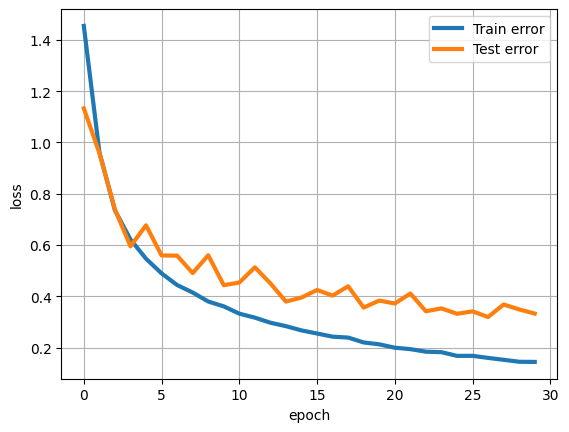

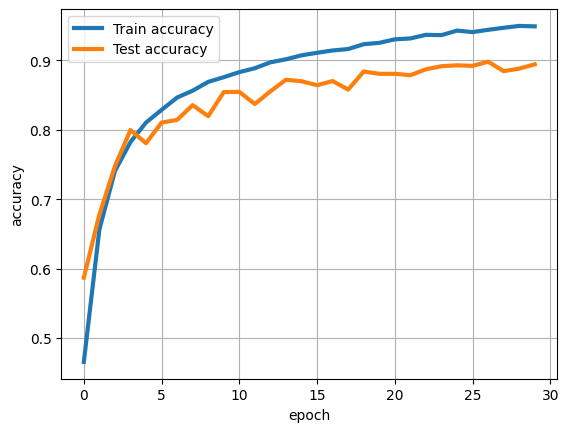

In [90]:
# Train the ResNet model and Classifying the Test Data
net_for_train_with_test = project_customized_model().cuda()
summary(net_for_train_with_test, (3, 32, 32))
train_with_test(net_for_train_with_test,
                train_valid_loader, 
                test_loader, 
                BATCH_SIZE,
                CHANNEL,
                EPOCH_NUM, 
                LR,
                LR_DECAY, 
                WEIGHT_DECAY, 
                LR_DECAY_PERIOD,
                MOMENTUM)

# **Step 9: Figure out the Best Performance**


*   Produce the Test Accuracy result based on this model
*   Get the top test accuracy model through model .pt file

In [91]:
#test the best test model acc
# start_time = "2023-04-07 21:11:59.803520"
# f = open("Train_With_Test_Log/"+str(start_time)+".txt",'a')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = project_customized_model().to(device)
# model_path = 'Train_With_Test_Model/' + str(start_time) + '_model.pt'
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
# loss = nn.CrossEntropyLoss()
# test_loss = 0.0
# test_acc = 0.0
# model.eval()
# for j, data in enumerate(test_loader):
#     with torch.no_grad():
#         images, labels = data
#         images = images.cuda()
#         labels = labels.cuda()
#         predicted_output = model(images)
#         fit = loss(predicted_output,labels)
#         test_loss += fit.item()
#         _, pred = predicted_output.max(1)
#         num_correct = (pred==labels).sum().item()
#         acc = num_correct / images.shape[0]
#         test_acc += acc
# test_loss = test_loss / len(test_loader)
# test_acc = test_acc / len(test_loader)
# epoch_end_time = datetime.datetime.now()
# # print('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc))
# print("-------------------------------------------------")
# line_new = "{:>15} {:>15} {:>15}".format(
#         "Best Model Saved", "Test loss", "Test acc")
# print(line_new)
# print("#################################################")
# line_new = "{:>15} {:>15} {:>15}".format(
#     "Best model",
#     round(test_loss, 5),
#     round(test_acc, 5))
# print(line_new)
# print("-------------------------------------------------")
# print("\n")
# f.write('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc)+'\n')

# # test the output of the model
# predicted_output = model(images)
# print(torch.max(predicted_output, 1))
# f.write(str(torch.max(predicted_output, 1))+'\n')
# fit = loss(predicted_output, labels)
# print(labels)
# f.write(str(labels)+'\n')
# print(fit)
# f.write(str(fit)+'\n')
# f.close()

# plt.figure(figsize=(10,10))
# for idx in np.arange(0,16):
#     plt.subplot(4,4,idx+1)
#     plt.imshow(images[idx].cpu()[0,:,:].squeeze(), cmap=plt.cm.gray)
# plt.savefig('Train_With_Test_Log/'+str(start_time)+'_test_instances.png')
